# Data Review: Player Performance Pre- and Post-Transfer 📊⚽

This notebook reviews the main Twelve Football transfer dataset, focusing on player performance before and after a transfer. The goal is to understand the dataset’s structure, granularity, and potential caveats prior to defining the unit of analysis and modeling transferability.


## 0) Imports & Setup

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
PATH = "../../raw_data_agust_12/male_transfers_data.parquet"

## 1) Quick Snapshot

Quick structural check of the main parquet.

	•	Shape: 77,782 rows × 366 columns
	•	Types: overwhelmingly numeric (float32) → aggregated performance metrics 📊
	•	Exact duplicates: none ✅

We verify uniqueness at the full intended granularity:

player_id × from_competition × to_competition ×
from_season × to_season × position_from × position

At this level, the number of unique rows equals the total number of rows.

In [3]:
df = pd.read_parquet(PATH)
df.shape
df

,player_id,gender,from_competition,to_competition,from_team_id,to_team_id,from_season,to_season,last_played_date,first_played_date,...,z_score_xA per 90_from,z_score_xG + xA per 100 touches_from,z_score_xG per 90_from,z_score_xG per box touch_from,z_score_xG per shot_from,z_score_xGBuildup per 90_from,z_score_xGChain per possession_from,z_score_xGCreated per 90_from,z_score_xGDribble per 90_from,z_score_xGOT per 90_from
3541,39558,male,127,546,8714,10985,2018,2019,2018-12-23 12:30:00,2019-04-07 12:00:00,...,-0.230178,-0.668823,-0.442331,NaN,-0.764173,1.161678,0.126879,-0.465592,-0.178910,0.081343
3542,40619,male,127,546,8682,10989,2018,2019,2018-12-21 15:30:00,2019-03-09 09:00:00,...,-0.272412,-0.794302,-0.253436,0.689239,-0.400522,-0.573538,-0.866235,-0.276468,-0.689415,0.295396
3543,40619,male,127,546,8682,10989,2018,2019,2018-12-21 15:30:00,2019-03-09 09:00:00,...,-1.127887,-0.854912,-0.446597,0.141068,0.127532,-0.689799,-1.503197,-0.899362,-0.918006,0.053274
3544,64543,male,127,43114,8714,63764,2018,2019,2018-11-12 13:00:00,2019-03-30 23:00:00,...,2.616989,0.968465,-1.040329,NaN,-1.093720,-1.102712,-0.830265,-0.606746,-0.529227,-0.797386
3545,64543,male,127,43114,8714,63764,2018,2019,2018-11-12 13:00:00,2019-03-30 23:00:00,...,2.980954,1.350675,-1.363574,-0.517759,-1.490842,0.158656,-0.191947,0.990421,-0.713805,-1.607982
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81318,1182152,male,43765,43074,64750,60047,2025,2025,2025-10-05 15:00:00,2025-05-11 13:00:00,...,-0.750316,-0.616847,-0.434732,-0.514981,-0.632163,-0.695088,-0.608418,0.294651,-0.885861,0.028172
81319,1182743,male,43765,43074,77728,77755,2025,2025,2025-10-02 19:00:00,2025-04-13 13:00:00,...,3.470421,2.144065,0.307080,NaN,-0.457620,1.064138,1.748087,2.799668,-0.249733,-0.024264
81320,1185912,male,43765,43074,77764,77723,2025,2025,2025-09-27 13:00:00,2025-05-17 13:00:00,...,-0.636136,-0.568316,-0.478866,NaN,0.881620,-0.661212,-0.286588,-0.897867,-0.249733,-0.610104
81321,1185930,male,43765,43074,77764,77723,2025,2025,2025-10-04 15:00:00,2025-08-10 12:00:00,...,-0.540403,-0.561404,NaN,NaN,NaN,1.457783,1.815510,-0.381538,NaN,NaN


In [4]:
df.dtypes.value_counts()

float32    342
int32       13
object       8
int16        2
float64      1
Name: count, dtype: int64

In [5]:
df.duplicated().mean(), df[df.duplicated()].shape

(np.float64(0.0), (0, 366))

In [6]:
keys_pos = [
    "player_id",
    "from_competition",
    "to_competition",
    "from_season",
    "to_season",
    "position_from",
    "position",
]

n_rows = len(df)
n_unique = df[keys_pos].drop_duplicates().shape[0]
n_repeated_rows = n_rows - n_unique

n_rows, n_unique, n_repeated_rows

(77782, 77782, 0)

## 2) Review of Positional Changes 

Players can appear in multiple positions within the same season, both before and after a transfer. We therefore inspect positional changes at the player–transfer level.

What we observe:

	•	Most transfers are 1 → 1 (same positional cardinality)
	•	A substantial number are 1 → 2 or 2 → 1
	•	A few involve 3 positions, but these are rare 

To check whether multi-position cases are trivial, we look at minutes distribution across positions:

	•	Median dominant-position share ≈ 60%
	•	75% of cases below ≈ 68%
	•	Almost no cases are close to 90/10

Takeaway:
Multi-position seasons are not “one main role + cameo”, but true role sharing (≈60/40–70/30). As a result, position is informative and cannot be safely collapsed when testing the thesis hypothesis (if relevant).

In [7]:
keys_transfer = [
    "player_id",
    "from_competition",
    "to_competition",
    "from_season",
    "to_season",
]

# primero: resumen a nivel player–transfer
transfer_summary = (
    df.groupby(keys_transfer)
      .agg(
          n_pos_from=("position_from","nunique"),
          n_pos_to=("position","nunique"),
          n_rows=("position_from","size")   # filas reales en el parquet
      )
      .reset_index()
)

# ahora: tabla final por combinación
combo_table = (
    transfer_summary
    .groupby(["n_pos_from","n_pos_to"])
    .agg(
        count_transfers=("player_id","count"),
        count_rows=("n_rows","sum")
    )
    .reset_index()
    .sort_values(["n_pos_from","n_pos_to"])
)

combo_table

,n_pos_from,n_pos_to,count_transfers,count_rows
0,1,1,57992,57992
1,1,2,3895,7790
2,1,3,135,405
3,2,1,3441,6882
4,2,2,939,3756
5,2,3,38,228
6,3,1,120,360
7,3,2,45,270
8,3,3,11,99


In [8]:
combo_table["count_rows"].sum(), len(df)

(np.int64(77782), 77782)

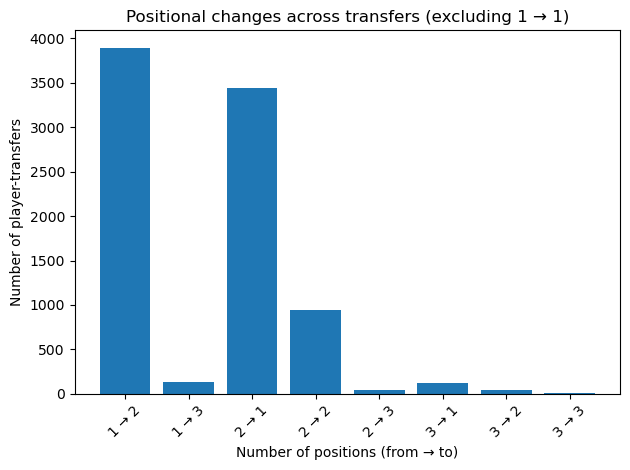

In [9]:
plot_df = combo_table[
    ~((combo_table["n_pos_from"] == 1) & (combo_table["n_pos_to"] == 1))
].copy()

plot_df["combo"] = (
    plot_df["n_pos_from"].astype(str) + " → " + plot_df["n_pos_to"].astype(str)
)

plt.figure()
plt.bar(plot_df["combo"], plot_df["count_transfers"])
plt.xlabel("Number of positions (from → to)")
plt.ylabel("Number of player-transfers")
plt.title("Positional changes across transfers (excluding 1 → 1)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [10]:
keys_transfer = [
    "player_id",
    "from_competition",
    "to_competition",
    "from_season",
    "to_season",
]

pos_changes = (
    df.groupby(keys_transfer)
      .agg(
          pos_from=("position_from", lambda x: ",".join(sorted(x.unique()))),
          pos_to=("position", lambda x: ",".join(sorted(x.unique()))),
          n_pos_from=("position_from", "nunique"),
          n_pos_to=("position", "nunique"),
      )
      .reset_index()
)

# --- quedarnos SOLO con cambios de cardinalidad (1→2, 2→1, 1→3, etc.) ---
change_table = (
    pos_changes
    .query("n_pos_from != n_pos_to")
    .groupby(["pos_from","pos_to","n_pos_from","n_pos_to"])
    .size()
    .reset_index(name="count")
    .sort_values("count", ascending=False)
    .reset_index(drop=True)
)

# --- seleccionar patrones que cubren ~80% de los casos ---
# --- seleccionar patrones que cubren ~90% de los casos ---
total = change_table["count"].sum()

change_table_90 = change_table.assign(
    cum_pct=lambda x: x["count"].cumsum() / total
)

cut = change_table_90["cum_pct"] <= 0.90
first_over = change_table_90.loc[~cut].head(1)

change_table_90 = pd.concat(
    [change_table_90.loc[cut], first_over],
    ignore_index=True
)

change_table_90

,pos_from,pos_to,n_pos_from,n_pos_to,count,cum_pct
0,Midfielder,"Midfielder,Winger",1,2,472,0.061506
1,Central Defender,"Central Defender,Full Back",1,2,448,0.119885
2,"Midfielder,Winger",Midfielder,2,1,443,0.177613
3,"Central Defender,Full Back",Central Defender,2,1,381,0.227261
4,Winger,"Striker,Winger",1,2,366,0.274954
5,"Central Defender,Full Back",Full Back,2,1,362,0.322127
6,Striker,"Striker,Winger",1,2,360,0.369038
7,Full Back,"Central Defender,Full Back",1,2,333,0.412432
8,Winger,"Midfielder,Winger",1,2,323,0.454522
9,"Striker,Winger",Striker,2,1,318,0.495960


In [11]:
keys_transfer = [
    "player_id",
    "from_competition",
    "to_competition",
    "from_season",
    "to_season",
]

# quedarnos solo con transfers multi-posición en FROM
df_multi = (
    df.groupby(keys_transfer)
      .filter(lambda x: x["position_from"].nunique() > 1)
)

# minutos por posición
minute_shares = (
    df_multi
    .groupby(keys_transfer + ["position_from"])["Minutes_from"]
    .sum()
    .reset_index()
)

# total minutos por transfer
minute_shares["total_minutes"] = (
    minute_shares.groupby(keys_transfer)["Minutes_from"]
    .transform("sum")
)

# share por posición
minute_shares["share"] = (
    minute_shares["Minutes_from"] / minute_shares["total_minutes"]
)

# quedarnos con la posición dominante (max share)
dominance = (
    minute_shares
    .groupby(keys_transfer)["share"]
    .max()
)

dominance.describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9])

count    4594.000000
mean        0.615378
std         0.089895
min         0.340228
10%         0.514782
25%         0.544800
50%         0.604520
75%         0.681396
90%         0.742198
max         0.903122
Name: share, dtype: float64

In [12]:
# multi-posición en TO
df_multi_to = (
    df.groupby(keys_transfer)
      .filter(lambda x: x["position"].nunique() > 1)
)

minute_shares_to = (
    df_multi_to
    .groupby(keys_transfer + ["position"])["Minutes"]
    .sum()
    .reset_index()
)

minute_shares_to["total_minutes"] = (
    minute_shares_to.groupby(keys_transfer)["Minutes"]
    .transform("sum")
)

minute_shares_to["share"] = (
    minute_shares_to["Minutes"] / minute_shares_to["total_minutes"]
)

dominance_to = (
    minute_shares_to
    .groupby(keys_transfer)["share"]
    .max()
)

dominance_to.describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9])

count    5063.000000
mean        0.618295
std         0.090461
min         0.342131
10%         0.515802
25%         0.547089
50%         0.608247
75%         0.683278
90%         0.745918
max         0.917130
Name: share, dtype: float64

## 3) Promotion / Relegation / Regional Leagues

In [13]:
promo_releg = df[
    (df["from_team_id"] == df["to_team_id"]) &
    (df["from_competition"] != df["to_competition"])
]

promo_releg.shape

(21353, 366)

In [14]:
len(promo_releg) / len(df)

0.2745236687151269

In [15]:
promo_releg[
    ["player_id","from_team_id","from_competition","to_competition","from_season","to_season"]
].drop_duplicates().head(10)

,player_id,from_team_id,from_competition,to_competition,from_season,to_season
3800,86263,12215,139,143,2023,2024
3806,88677,12215,139,143,2023,2024
3807,88706,12215,139,143,2023,2024
3809,88786,12215,139,143,2023,2024
3811,89106,12215,139,143,2023,2024
3813,146124,12215,139,143,2023,2024
3817,219723,12215,139,143,2023,2024
3836,417957,12215,139,143,2023,2024
3859,718156,12215,139,143,2023,2024
3872,893769,12215,139,143,2023,2024


In [16]:
df["same_club_diff_comp"] = (
    (df["from_team_id"] == df["to_team_id"]) &
    (df["from_competition"] != df["to_competition"])
)

df["same_season_multi_comp"] = (
    df["same_club_diff_comp"] &
    (df["from_season"] == df["to_season"])
)

df["promotion_relegation"] = (
    df["same_club_diff_comp"] &
    (df["from_season"] != df["to_season"])
)

df[["same_club_diff_comp","promotion_relegation","same_season_multi_comp"]].mean()

same_club_diff_comp       0.274524
promotion_relegation      0.244324
same_season_multi_comp    0.030200
dtype: float64

## Transfer Dataset Review Summary (Twelve Football)

- No exact duplicates at the full intended granularity:
  - `player_id × from_competition × to_competition × from_season × to_season × position_from × position`
- Apparent duplicates at coarser levels are explained by positional granularity (multiple rows per transfer when a player appears in multiple positions).
- Multi-position seasons are common (up to 3 positions) and reflect real role sharing:
  - Dominant-position minutes share is typically ~60/40–70/30 rather than “main role + cameo”.
  - The same pattern holds pre- and post-transfer.
- Implication: if position is relevant for the thesis hypothesis, it must be modeled explicitly (e.g., position-level analysis or weighted aggregation), not collapsed blindly.

### Competition / context caveats
- A substantial share of rows correspond to players staying at the same club while changing competition:
  - ~27% same club + different competition
  - ~24% promotion/relegation (season changes)
  - ~3% multiple competitions within the same season
- These cases represent changes in competitive context rather than club transfers and should be flagged for downstream analysis.